<a href="https://www.kaggle.com/code/chadmiratnayake/expression-of-genes-in-aml-and-all-type-leukemia?scriptVersionId=235565923" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# --- 1. Load the Data ---
actual_df = pd.read_csv("/kaggle/input/gene-expression/actual.csv")
independent_df = pd.read_csv("/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv")
train_df = pd.read_csv("/kaggle/input/gene-expression/data_set_ALL_AML_train.csv")

In [3]:
#Encode labels
actual_df = actual_df.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML']

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [4]:
#drop call columns
train_needed = [col for col in train_df.columns if "call" not in col]
test_needed = [col for col in independent_df.columns if "call" not in col]

X_train_org = train_df[train_needed]
X_test_org = independent_df[test_needed]

In [5]:
X_train_org.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


In [6]:
X_test_org.head()

,Gene Description,Gene Accession Number,39,40,42,47,48,49,41,43,...,54,57,58,60,61,65,66,63,64,62
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,-87,22,-243,-130,-256,-62,86,...,-90,-137,-157,-172,-47,-62,-58,-161,-48,-176
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,-248,-153,-218,-177,-249,-23,-36,...,-87,-51,-370,-122,-442,-198,-217,-215,-531,-284
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,262,17,-163,-28,-410,-7,-141,...,102,-82,-77,38,-21,-5,63,-46,-124,-81
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,295,276,182,266,24,142,252,...,319,178,340,31,396,141,95,146,431,9
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,-226,-211,-289,-170,-535,-233,-201,...,-283,-135,-438,-201,-351,-256,-191,-172,-496,-294


In [7]:
train_columns_titles = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(1, 39)]
test_columns_titles = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(39, 73)]

X_train_org = X_train_org.reindex(columns=train_columns_titles)
X_test_org = X_test_org.reindex(columns=test_columns_titles)

In [8]:
X_train = X_train_org.T
X_test = X_test_org.T

In [9]:
#Rename Columns to Gene Names & Drop Metadata Rows
X_train.columns = X_train.iloc[1]  
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]  
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

In [10]:
X_train = X_train.reset_index(drop=True)
y_train = actual_df[actual_df.patient <= 38].reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = actual_df[actual_df.patient > 38].reset_index(drop=True)

Logistic Regression accuracy: 0.9706


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

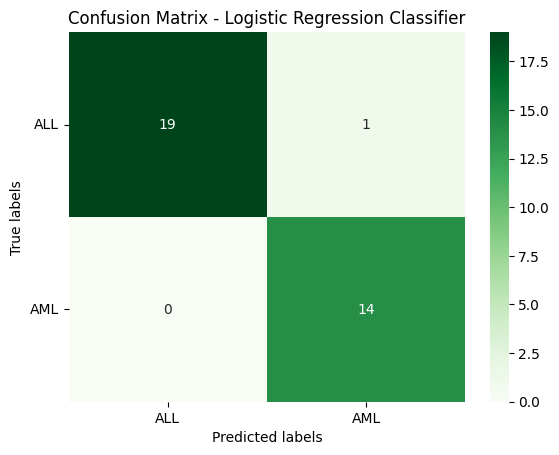

In [11]:
# Model 1: LogisticRegression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train.iloc[:, 1])

logreg_pred = logreg_model.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:, 1], logreg_pred), 4))

cm_logreg = confusion_matrix(y_test.iloc[:, 1], logreg_pred)

ax = plt.subplot()
sns.heatmap(cm_logreg, annot=True, ax=ax, fmt='g', cmap='Greens')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic Regression Classifier')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

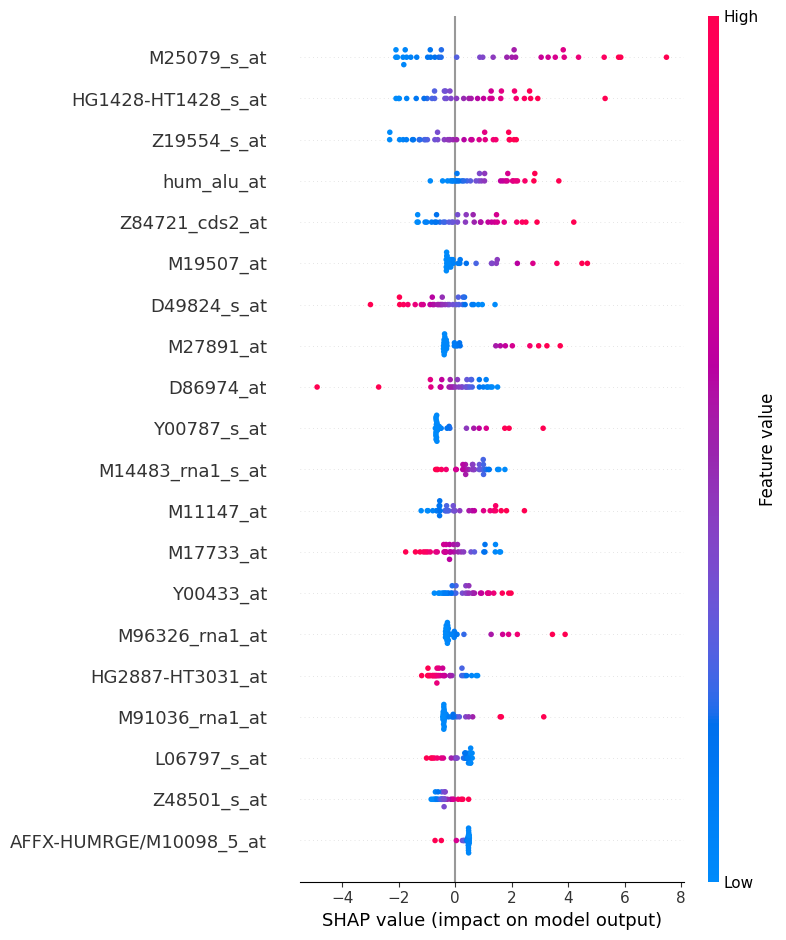

In [12]:
# Create a SHAP explainer for the linear model
explainer = shap.LinearExplainer(logreg_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary Plot of Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


Decision Tree accuracy: 0.9118


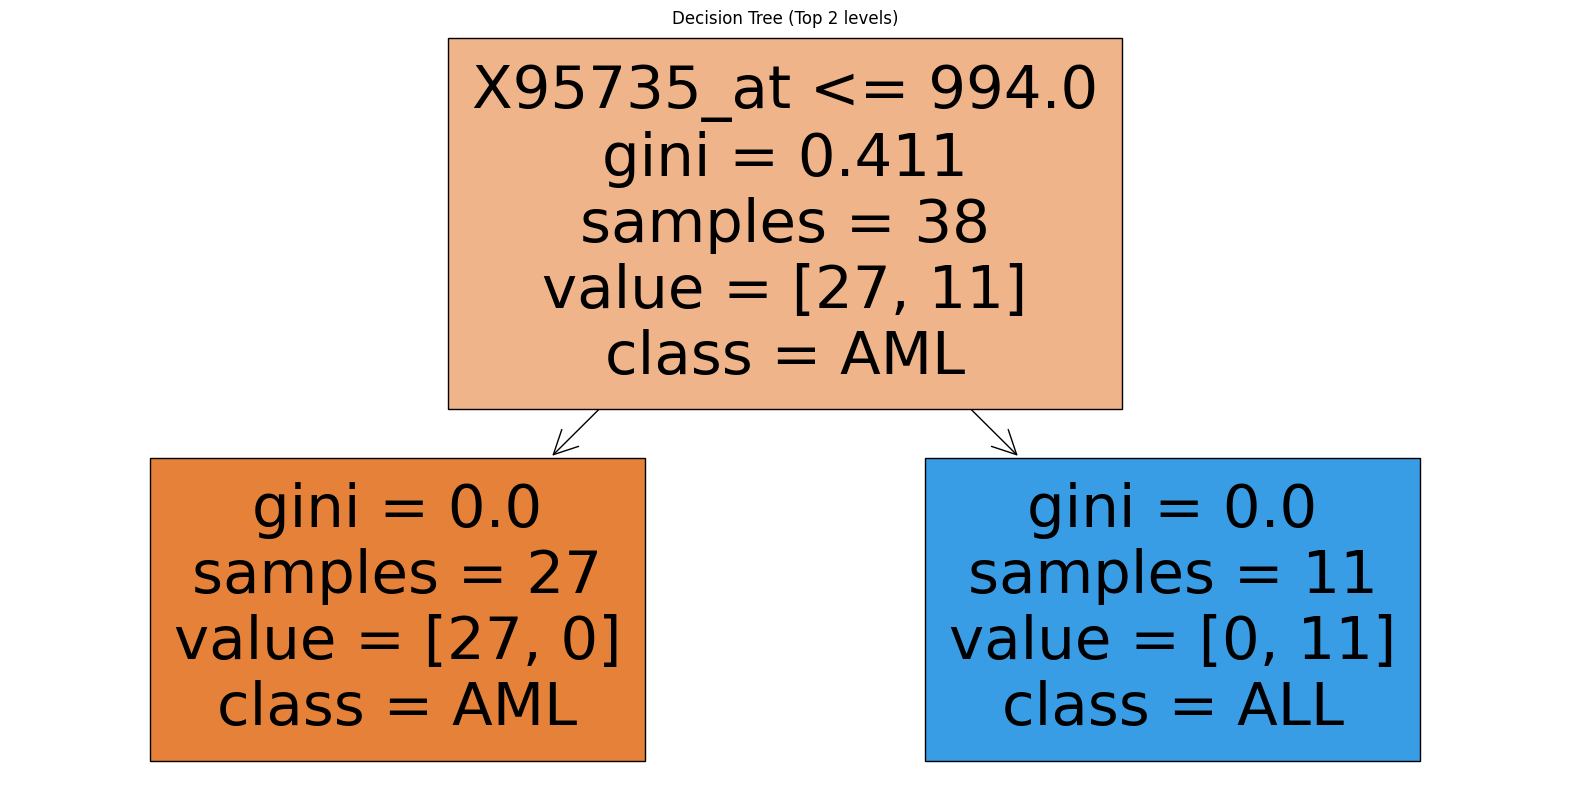

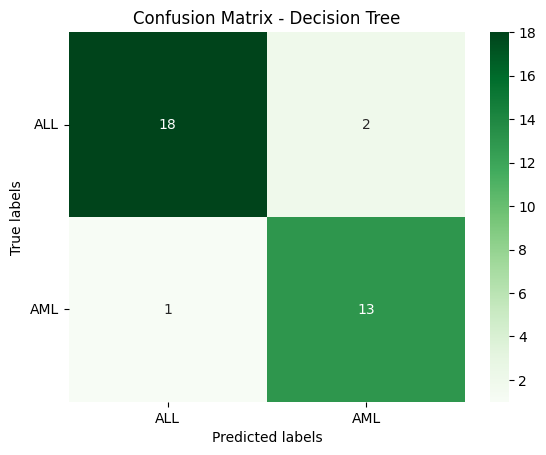

In [13]:
# Model 2: Decision Tree
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train, y_train.iloc[:, 1])

dtree_pred = dtree.predict(X_test)

print('Decision Tree accuracy:', round(accuracy_score(y_test.iloc[:, 1], dtree_pred), 4))

# Plot tree
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=X_train.columns, class_names=['AML', 'ALL'], filled=True, max_depth=2)
plt.title("Decision Tree (Top 2 levels)")
plt.show()

cm_dtree = confusion_matrix(y_test.iloc[:, 1], dtree_pred)

ax = plt.subplot()
sns.heatmap(cm_dtree, annot=True, ax=ax, fmt='g', cmap='Greens') 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Decision Tree')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

plt.show()

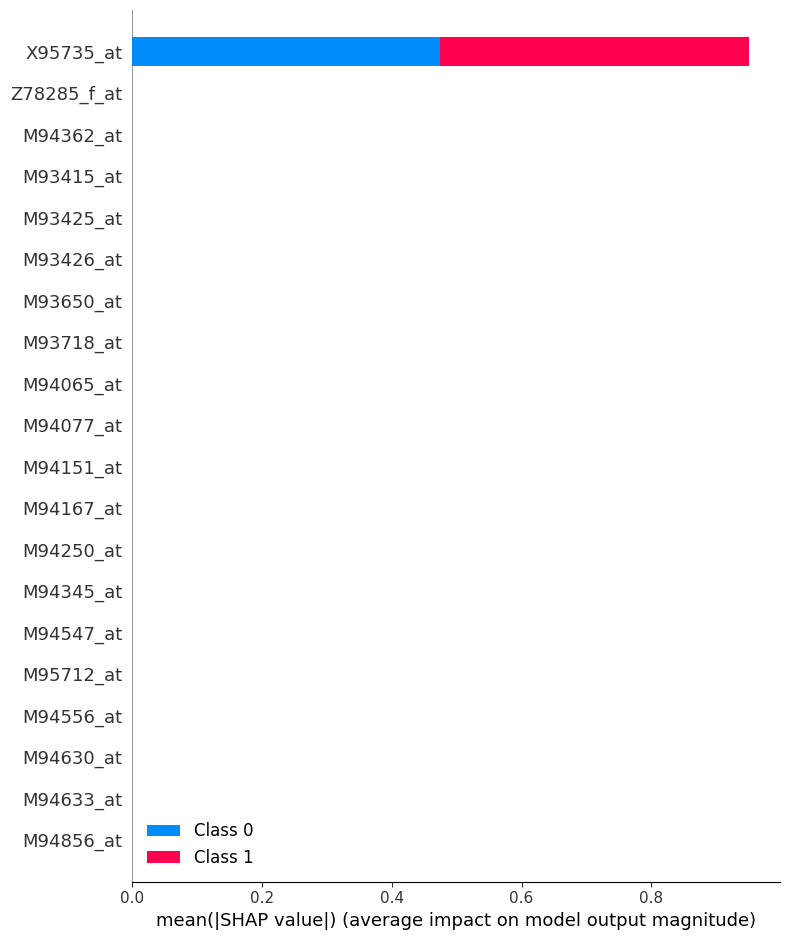

In [14]:
# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(dtree)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary Plot of Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [15]:
coefs = logreg_model.coef_[0]
feature_names = X_train.columns

top_positive = np.argsort(coefs)[-10:]  # features pushing towards AML (e.g., class 1)
top_negative = np.argsort(coefs)[:10]   # features pushing towards ALL (e.g., class 0)

print("Top genes associated with AML (positive weights):")
for i in reversed(top_positive):
    print(f"{feature_names[i]}: {coefs[i]:.4f}")

print("\nTop genes associated with ALL (negative weights):")
for i in top_negative:
    print(f"{feature_names[i]}: {coefs[i]:.4f}")

Top genes associated with AML (positive weights):
Y00787_s_at: 0.0002
M19507_at: 0.0002
Z19554_s_at: 0.0002
M27891_at: 0.0002
M25079_s_at: 0.0001
M96326_rna1_at: 0.0001
M11147_at: 0.0001
M91036_rna1_at: 0.0001
M69043_at: 0.0001
Y00433_at: 0.0001

Top genes associated with ALL (negative weights):
M17733_at: -0.0002
AFFX-HUMRGE/M10098_3_at: -0.0001
M14483_rna1_s_at: -0.0001
L06797_s_at: -0.0001
AFFX-HUMRGE/M10098_5_at: -0.0001
L20688_at: -0.0001
D49824_s_at: -0.0001
M13792_at: -0.0001
D86974_at: -0.0001
HG2887-HT3031_at: -0.0001


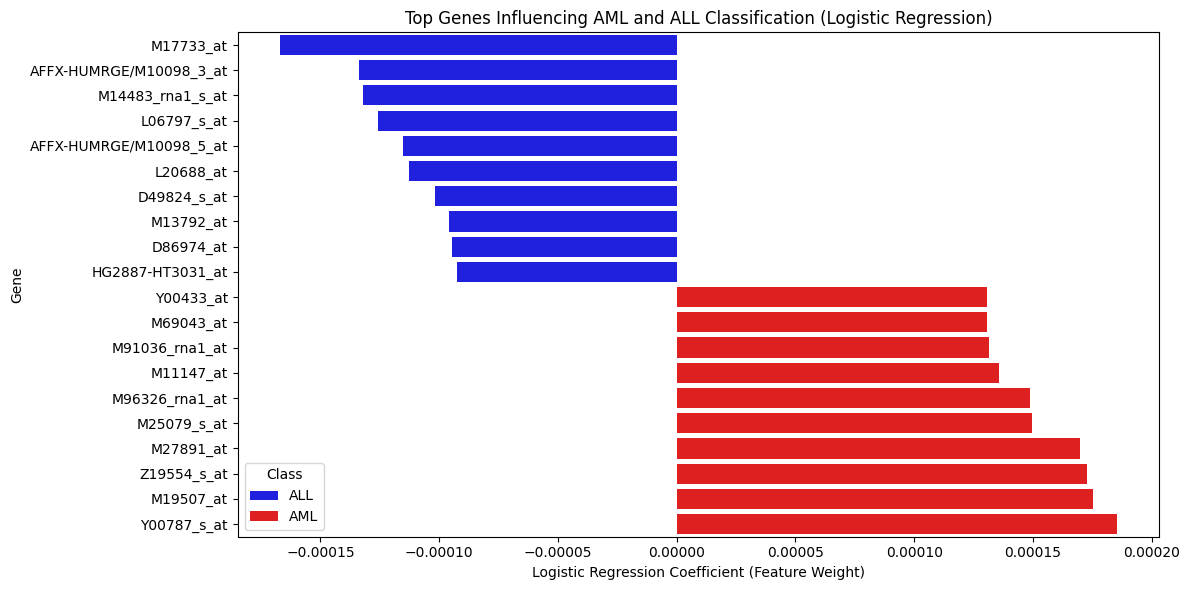

In [16]:
# Extract coefficients and feature names
coefs = logreg_model.coef_[0]
feature_names = X_train.columns

# Top 10 positive (AML) and negative (ALL) coefficients
top_positive_indices = np.argsort(coefs)[-10:]
top_negative_indices = np.argsort(coefs)[:10]

top_features = np.concatenate([top_negative_indices, top_positive_indices])
top_genes = feature_names[top_features]
top_weights = coefs[top_features]

df_plot = pd.DataFrame({
    'Gene': top_genes,
    'Weight': top_weights,
    'Class': ['ALL'] * 10 + ['AML'] * 10
})

# Sort for better visualization
df_plot = df_plot.sort_values('Weight')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Weight', y='Gene', data=df_plot, hue='Class', dodge=False, palette={'AML': 'red', 'ALL': 'blue'})
plt.title('Top Genes Influencing AML and ALL Classification (Logistic Regression)')
plt.xlabel('Logistic Regression Coefficient (Feature Weight)')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()


In [17]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=18).fit(X_train)

cm = confusion_matrix(kmeans.labels_, y_train.iloc[:,1])

max_vals = np.amax(cm, axis=1)

purity = np.sum(max_vals) / len(y_train.iloc[:,1])

print('Purity of the kmeans clustering:', purity)

Purity of the kmeans clustering: 0.9736842105263158


In [18]:
# from sklearn.decomposition import PCA

# # Reduce the data to 2D with PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train)

# # Get cluster labels
# cluster_labels = kmeans.labels_

# # Plot KMeans clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set1', s=60, edgecolor='k')
# plt.title('KMeans Clustering on PCA-Reduced Gene Expression Data')
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
# plt.legend(title='KMeans Cluster')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [19]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X_train)
agg_labels = agg_clustering.labels_
cm_agg = confusion_matrix(agg_labels, y_train.iloc[:, 1])

max_vals_agg = np.amax(cm_agg, axis=1)
purity_agg = np.sum(max_vals_agg) / len(y_train.iloc[:, 1])

print(f'Purity of Agglomerative Clustering (linkage=\'{agg_clustering.linkage}\'): {round(purity_agg, 4)}')

Purity of Agglomerative Clustering (linkage='ward'): 0.8158


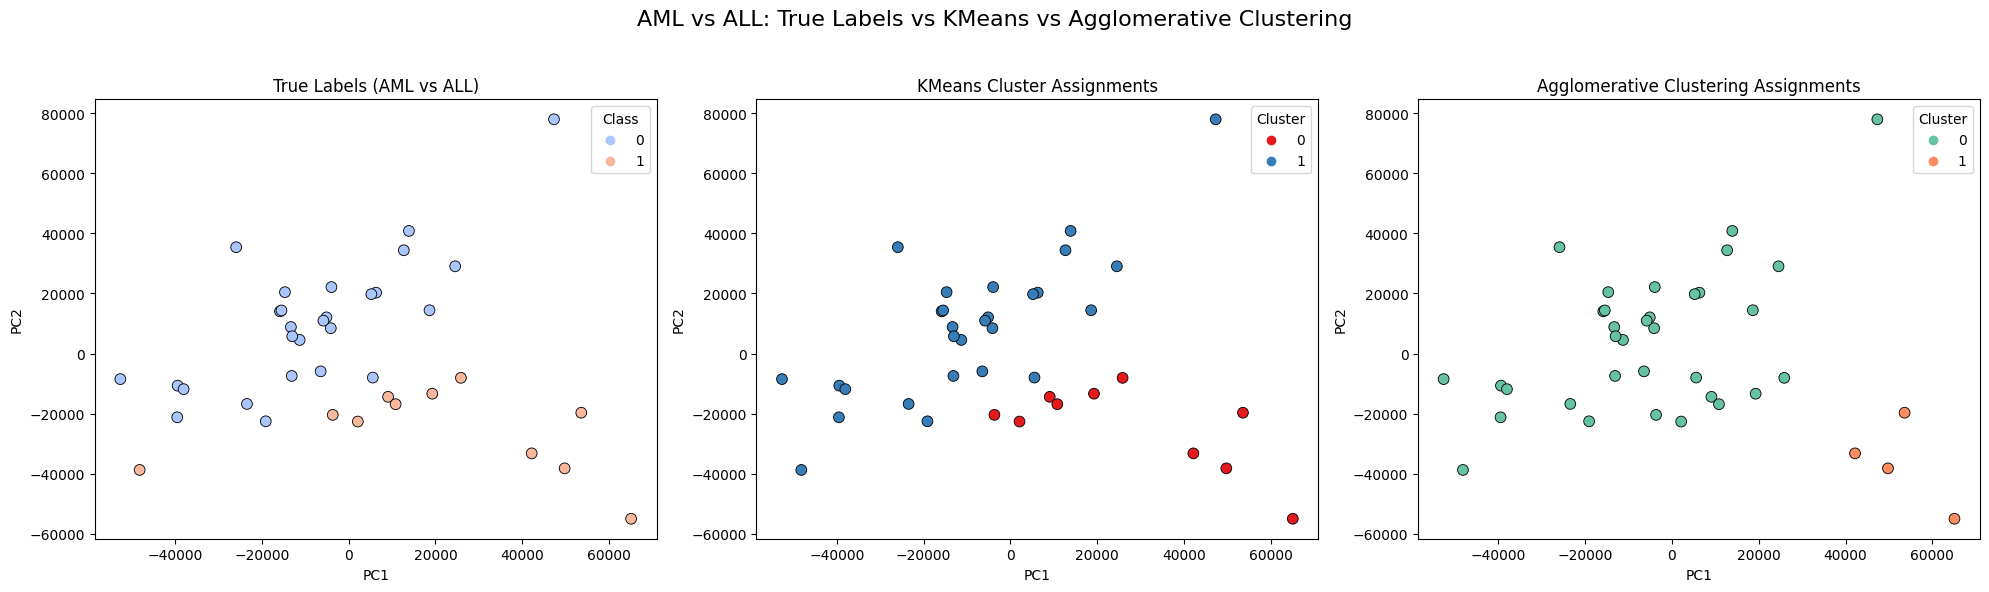

In [20]:
# PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 1. True Labels
sns.scatterplot(ax=axs[0], x=X_pca[:, 0], y=X_pca[:, 1],
                hue=y_train.iloc[:, 1], palette='coolwarm', s=60, edgecolor='k')
axs[0].set_title('True Labels (AML vs ALL)')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend(title='Class')

# 2. KMeans Clusters
sns.scatterplot(ax=axs[1], x=X_pca[:, 0], y=X_pca[:, 1],
                hue=kmeans.labels_, palette='Set1', s=60, edgecolor='k')
axs[1].set_title('KMeans Cluster Assignments')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].legend(title='Cluster')

# 3. Agglomerative Clusters
sns.scatterplot(ax=axs[2], x=X_pca[:, 0], y=X_pca[:, 1],
                hue=agg_clustering.labels_, palette='Set2', s=60, edgecolor='k')
axs[2].set_title('Agglomerative Clustering Assignments')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].legend(title='Cluster')

plt.suptitle('AML vs ALL: True Labels vs KMeans vs Agglomerative Clustering', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
